In [8]:
# Check the column names in both datasets
print(customers.columns)
print(transactions.columns)


Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


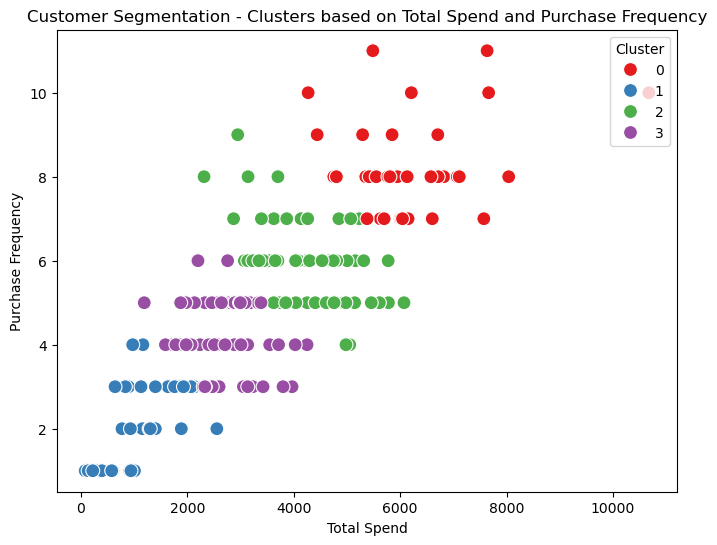

DB Index Value: 0.8595340221510475
Cluster Centers: [[ 1.47967544  1.47391604]
 [-1.24019624 -1.27695794]
 [ 0.44050613  0.42829076]
 [-0.3948402  -0.36019156]]


In [18]:
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warning related to KMeans
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak on Windows with MKL")

# Set the environment variable to avoid memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Aggregate transaction data to create features like total spend and purchase frequency
transaction_agg = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count')
).reset_index()

# Merge demographic data with aggregated transaction data
merged_data = pd.merge(customers, transaction_agg, on='CustomerID')

# Feature selection: Demographic and Transaction Features
features = merged_data[['CustomerID', 'Region', 'TotalSpend', 'PurchaseFrequency']].copy()

# Data Preprocessing: Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['TotalSpend', 'PurchaseFrequency']])

# Apply KMeans clustering with 4 clusters (you can change this between 2-10)
kmeans = KMeans(n_clusters=4, random_state=42)
features['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate DB Index for evaluating clustering quality
db_index = davies_bouldin_score(scaled_features, features['Cluster'])

# Visualization of the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features['TotalSpend'], y=features['PurchaseFrequency'], hue=features['Cluster'], palette='Set1', s=100)
plt.title('Customer Segmentation - Clusters based on Total Spend and Purchase Frequency')
plt.xlabel('Total Spend')
plt.ylabel('Purchase Frequency')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Output DB Index and cluster details
print(f"DB Index Value: {db_index}")
print("Cluster Centers:", kmeans.cluster_centers_)

# Save the clustered data to CSV
features.to_csv('customer_segments.csv', index=False)
